In [30]:


import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import os.path
import datetime
import winsound
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import loguniform
from sklearn.inspection import permutation_importance
import sys
from sklearn.model_selection import StratifiedShuffleSplit
import os
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import os.path
from openpyxl import Workbook, load_workbook
import xgboost as xgb
from scipy.stats import randint
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from sklearn.svm import SVC
from pandas_profiling import ProfileReport
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import pointbiserialr
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(threshold=sys.maxsize, suppress=True)

In [31]:
# After cleaning my initial dataset I saved the data into CSV format again so the cleaned and aligned dataset can act like original source for the other researchers who want to use this dataset.
# Problem, is that saving it to CSV to not preserve datatypes, so I have to make them categorical again.
datatypes = {'business_area': str, 'sex': str, 'employment_status': str,
            'time': str, 'severity': str, 'enterprise_size': str,
            'citizenship': str, 'profession_code': str, 'type_of_injury': str
            , 'injured_bodypart': str, 'workstation': str,
            'working_environment': str, 'working_process': str
            , 'specific_physical_activity': str,
            'material_agent_of_physical_act.': str,
            'deviation': str, 'material_agent_of_deviation': str
            , 'contact_mode_of_injury': str, 'material_agent_of_contact_mode': str, 'general_profession_code': str, 'month': str, 'weekofyear': str, 'dayofweek': str, 'material_agent_of_physical_act': str}

In [32]:
os.chdir('/Users/Mario/OneDrive/Desktop/Final code for thesis')
df = pd.read_csv('data.csv', dtype = datatypes, encoding='latin-1', index_col=0)
df = df.drop(columns= ['date', 'time', 'datetime', 'time_ESAW', 'lost_days', 'type_of_injury', 'injured_bodypart', 'severity'])

In [33]:
sector = 'G'
occup_class = 7
df = df[(df['business_sector'] == sector)].copy()
df = df[(df['general_profession_class'] == occup_class)].copy()
df = df.drop(columns=['business_sector', 'general_profession_class'])
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [34]:
# G7 hand-picked features
df = df[['business_area', 'age', 'full_hours_from_startofwork', 'location', 'citizenship', 'profession_code', 'working_process', 'specific_physical_activity', 'material_agent_of_physical_act', 'deviation', 'material_agent_of_deviation', 'contact_mode_of_injury', 'material_agent_of_contact_mode', 'enterprise_size_ordinal_enc', 'dayofweek', 'month', 'sin_time', 'cos_time', 'temperature', 'cause code 001', 'cause code 002', 'cause code 003', 'cause code 004', 'cause code 005', 'cause code 006', 'cause code 008', 'cause code 009', 'cause code 011', 'cause code 014', 'cause code 025', 'target']]

In [35]:
all_object_cols = list(df.select_dtypes(include=['object']).columns)
df = pd.get_dummies(df, columns=all_object_cols)

# Separate independent variables and dependent variable for train set
X = df.drop(columns=['target'])
y = df['target']

# Balance the target class using random over-sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale float64 variables
float_cols = X_train.select_dtypes(include='float64').columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

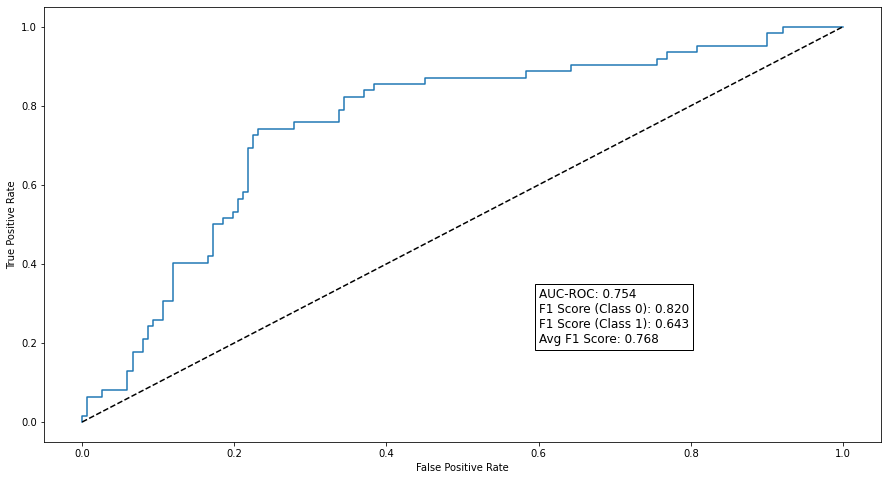

['age', 'cause code 005', 'cause code 008', 'full_hours_from_startofwork', 'contact_mode_of_injury_60']


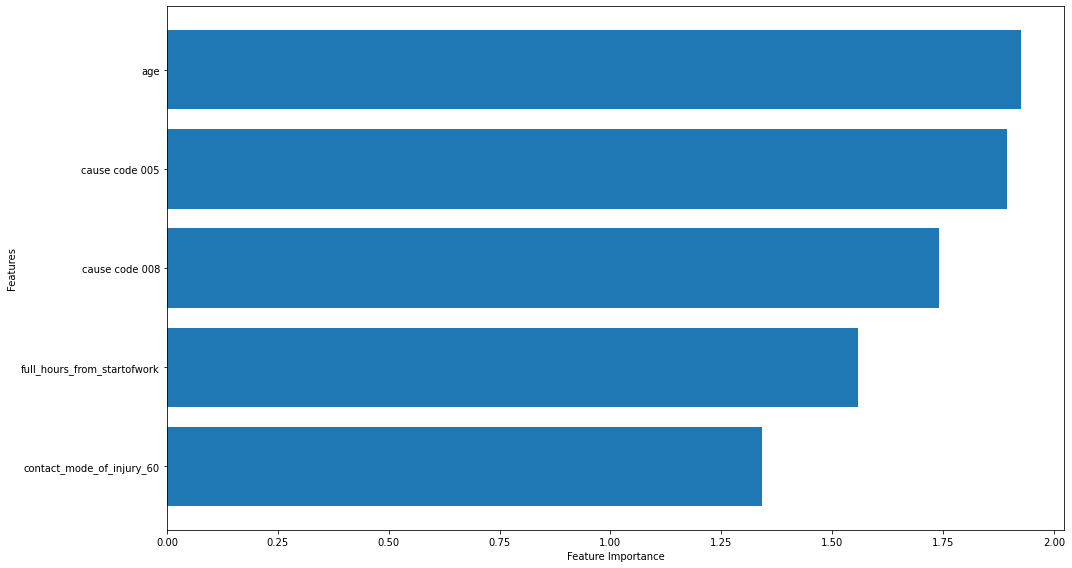

In [36]:
rs = 42
over_sampler = RandomOverSampler(random_state=rs)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)


rf_model = RandomForestClassifier(random_state=rs)
lgbm_model = LGBMClassifier(random_state=rs)
xgb_model = xgb.XGBClassifier(random_state=rs)
svm_model = SVC(kernel='rbf', probability=True, random_state=rs)
lr_model = LogisticRegression(max_iter=1000, random_state=rs, multi_class="ovr")

model = lr_model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)   
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
avg_f1 = f1_score(y_test, y_pred, average='weighted')


precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('LogReg ROC Curve')
plt.text(0.6, 0.2, f"AUC-ROC: {auc_roc:.3f}\nF1 Score (Class 0): {f1_class_0:.3f}\nF1 Score (Class 1): {f1_class_1:.3f}\nAvg F1 Score: {avg_f1:.3f}", fontsize=12, bbox=dict(facecolor='white'))
plt.show()

# calculate feature importance for class 1
importance = abs(lr_model.coef_[0])
feature_names = X_train.columns
# get the top 10 important features for class 1
indices = np.argsort(importance)[::-1][:5]
top_features = [feature_names[i] for i in indices]
top_importance = importance[indices]


print(top_features)
# plot the top 10 features
plt.figure(figsize=(15, 8))
#plt.title("Top 10 important features")
plt.barh(top_features, top_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis() # invert y-axis to show highest feature importance at the top
plt.tight_layout() # to adjust the plot layout
plt.show()